Our task in this project is to analyze baseball pitchers data from 2010 to 2023 to see if we can cluster them into a few groups. 

# Setup

In [1]:
!pip install scikit-plot
!pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 6.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 29.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import clone

import scikitplot as skplt
from pybaseball import pitching_stats

In [3]:
# suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load the Dataset

In [4]:
# Fetch pitching stats from season 2010 to 2023
data = pitching_stats(2010, 2023, ind=1, qual=10)
data

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
253,10954,2018,Jacob deGrom,NYM,30,10,9,9.0,1.70,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
723,1303,2011,Roy Halladay,PHI,34,19,6,8.7,2.35,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
501,2036,2015,Clayton Kershaw,LAD,27,16,7,8.6,2.13,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,2036,2014,Clayton Kershaw,LAD,26,21,3,7.9,1.77,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1483,10603,2017,Chris Sale,BOS,28,17,8,7.6,2.90,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7322,1646,2010,Brian Tallet,TOR,32,2,6,-1.3,6.40,34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7152,9388,2018,Josh Tomlin,CLE,33,2,5,-1.4,6.14,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7569,3245,2010,Ryan Rowland-Smith,SEA,27,1,10,-1.5,6.75,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5948,978,2011,Bronson Arroyo,CIN,34,9,12,-1.6,5.07,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8286 entries, 253 to 7713
Columns: 393 entries, IDfg to Pit+ FO
dtypes: float64(326), int64(63), object(4)
memory usage: 24.9+ MB


# Cleaning the Dataset

## Missing Values

In [6]:
# Check what features have missing values
pd.set_option('display.max_rows', 300)
na_sum = data.isna().sum(axis=0)
na_sum[na_sum > 0]

Starting      4056
Start-IP      4056
Relieving     1951
Relief-IP     1951
exLI             2
FB% 2           14
FBv             14
SL%           1761
SLv           1762
CT%           5982
CTv           5984
CB%           3162
CBv           3164
CH%           1631
CHv           1632
SF%           7390
SFv           7390
KN%           8258
KNv           8258
XX%           2394
PO%           8286
wFB             14
wSL           1761
wCT           5982
wCB           3162
wCH           1631
wSF           7390
wKN           8258
wFB/C           14
wSL/C         1761
wCT/C         5982
wCB/C         3162
wCH/C         1631
wSF/C         7390
wKN/C         8258
FA% (sc)       401
FT% (sc)      4804
FC% (sc)      5663
FS% (sc)      7533
FO% (sc)      8267
SI% (sc)      5056
SL% (sc)      1744
CU% (sc)      3526
KC% (sc)      7545
EP% (sc)      8198
CH% (sc)      1507
SC% (sc)      8273
KN% (sc)      8264
UN% (sc)      8286
vFA (sc)       401
vFT (sc)      4804
vFC (sc)      5663
vFS (sc)    

### Ignore Columns with too many Missing Values

In [7]:
# Drop features have too many missing values
drop_columns = na_sum[na_sum > 5000]
X = data.drop(columns = drop_columns.index.values)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8286 entries, 253 to 7713
Columns: 235 entries, IDfg to CSW%
dtypes: float64(168), int64(63), object(4)
memory usage: 14.9+ MB


### Impute Values

In [8]:
na_sum[(na_sum > 0) & (na_sum < 5000)]

Starting      4056
Start-IP      4056
Relieving     1951
Relief-IP     1951
exLI             2
FB% 2           14
FBv             14
SL%           1761
SLv           1762
CB%           3162
CBv           3164
CH%           1631
CHv           1632
XX%           2394
wFB             14
wSL           1761
wCB           3162
wCH           1631
wFB/C           14
wSL/C         1761
wCB/C         3162
wCH/C         1631
FA% (sc)       401
FT% (sc)      4804
SL% (sc)      1744
CU% (sc)      3526
CH% (sc)      1507
vFA (sc)       401
vFT (sc)      4804
vSL (sc)      1744
vCU (sc)      3526
vCH (sc)      1507
FA-X (sc)      401
FT-X (sc)     4804
SL-X (sc)     1744
CU-X (sc)     3526
CH-X (sc)     1507
FA-Z (sc)      401
FT-Z (sc)     4804
SL-Z (sc)     1744
CU-Z (sc)     3526
CH-Z (sc)     1507
wFA (sc)       401
wFT (sc)      4804
wSL (sc)      1744
wCU (sc)      3526
wCH (sc)      1507
wFA/C (sc)     401
wFT/C (sc)    4804
wSL/C (sc)    1744
wCU/C (sc)    3526
wCH/C (sc)    1507
CH% (pi)    

In [9]:
X.loc[X['Starting'].isna(),'Starting'] = 0
X.loc[X['Start-IP'].isna(),'Start-IP'] = 0
X.loc[X['Relieving'].isna(),'Relieving'] = 0
X.loc[X['Relief-IP'].isna(),'Relief-IP'] = 0

In [10]:
# impute mean to other missing values
for i in X.columns[X.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    X[i].fillna(X[i].mean(),inplace=True)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8286 entries, 253 to 7713
Columns: 235 entries, IDfg to CSW%
dtypes: float64(168), int64(63), object(4)
memory usage: 14.9+ MB


### Processing Columns with Object Types

In [12]:
data.select_dtypes(include=['object'])

,Name,Team,Dollars,Age Rng
253,Jacob deGrom,NYM,$72.3,30 - 30
723,Roy Halladay,PHI,$66.4,34 - 34
501,Clayton Kershaw,LAD,$68.4,27 - 27
291,Clayton Kershaw,LAD,$60.4,26 - 26
1483,Chris Sale,BOS,$61.0,28 - 28
...,...,...,...,...
7322,Brian Tallet,TOR,($8.0),32 - 32
7152,Josh Tomlin,CLE,($11.0),33 - 33
7569,Ryan Rowland-Smith,SEA,($9.1),27 - 27
5948,Bronson Arroyo,CIN,($12.0),34 - 34


In [13]:
# These 2 columns are not useful in analysis
X.drop(columns = ['IDfg', 'Name'], inplace=True)

In [14]:
# Factorize categorical features
team_codes, team_uniques = data['Team'].factorize()
age_rng_codes, age_rng_uniques = data['Age Rng'].factorize()

In [15]:
X['Team'] = team_codes
X['Age Rng'] = age_rng_codes

In [16]:
# processing dollars
# $10.0 -> 10.0
# ($10.0) -> -10.0
X['Dollars'] = X['Dollars'].replace('[\(]', '-', regex=True)
X['Dollars']

253       $72.3
723       $66.4
501       $68.4
291       $60.4
1483      $61.0
         ...   
7322     -$8.0)
7152    -$11.0)
7569     -$9.1)
5948    -$12.0)
7713    -$12.0)
Name: Dollars, Length: 8286, dtype: object

In [17]:
X['Dollars'] = X['Dollars'].replace('[\)$]', '', regex=True)
X['Dollars']

253      72.3
723      66.4
501      68.4
291      60.4
1483     61.0
        ...  
7322     -8.0
7152    -11.0
7569     -9.1
5948    -12.0
7713    -12.0
Name: Dollars, Length: 8286, dtype: object

In [18]:
X['Dollars'].astype(float)

253     72.3
723     66.4
501     68.4
291     60.4
1483    61.0
        ... 
7322    -8.0
7152   -11.0
7569    -9.1
5948   -12.0
7713   -12.0
Name: Dollars, Length: 8286, dtype: float64

In [19]:
# check features left
X.shape[1]

233

# Preprocessing the Dataset

## Standardize

In [20]:
X = StandardScaler().fit_transform(X)

In [21]:
X

array([[ 0.31462916, -1.59115091,  0.49655261, ...,  2.60195694,
        -0.16839112,  1.46366356],
       [-1.42321679, -1.48332347,  1.54843423, ..., -0.82788955,
         0.76873316,  0.76674843],
       [-0.43016197, -1.37549603, -0.2923586 , ...,  2.78177414,
        -0.16839112,  1.72915504],
       ...,
       [-1.6714805 , -0.29722166, -0.2923586 , ..., -0.82788955,
        -0.12376615, -1.65586132],
       [-1.42321679,  1.3201899 ,  1.54843423, ..., -0.82788955,
         1.03648296, -0.69345471],
       [-1.42321679, -0.83635884,  1.54843423, ..., -0.82788955,
        -0.25764105, -1.32399697]])

## Dimension Reduction Using PCA

In [22]:
pca = PCA(random_state=42)
pca.fit(X)

PCA(random_state=42)

<Axes: title={'center': 'PCA Component Explained Variances'}, xlabel='First n principal components', ylabel='Explained variance ratio of first n components'>

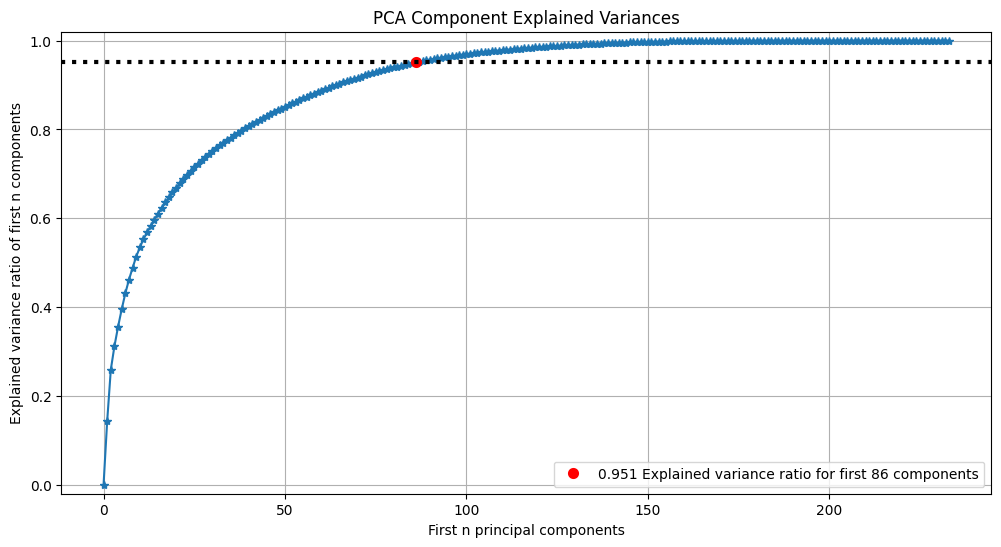

In [23]:
skplt.decomposition.plot_pca_component_variance(pca, target_explained_variance=0.95, figsize=(12, 6))

In [24]:
y = np.cumsum(pca.explained_variance_ratio_)
n_components_pca = np.where(y >= 0.95)[0][0]+1
print("# of Features Until 95% Variance is Reached:", n_components_pca)

# of Features Until 95% Variance is Reached: 86


In [25]:
pca_95 = PCA(n_components=n_components_pca, random_state=42)
_X = pca_95.fit_transform(X)

# Build and Traing Models

https://scikit-learn.org/stable/modules/clustering.html#clustering

## Train KMeans Models with Different Parameters

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [27]:
no_of_clusters = range(2, 21)

In [28]:
def train_model(base_model, no_of_clusters):
    silhouette_scores = []
    models = []
    for cluster in no_of_clusters:
        model = clone(base_model)
        model = model.set_params(**{'n_clusters': cluster})
        model = model.fit(_X)
        silhouette_avg = silhouette_score(_X, model.labels_)
        silhouette_scores.append(silhouette_avg)
        models.append(model)
    return silhouette_scores, models

In [29]:
silhouette_scores, kmeans_models = train_model(KMeans(random_state=42, n_init='auto'), no_of_clusters)

In [30]:
def plot_score(no_of_clusters, silhouette_scores):
  fig, ax = plt.subplots(figsize=(10, 6))
  plt.xticks(range(1, len(no_of_clusters)+1), no_of_clusters, fontsize=12, fontweight="bold")
  ax.plot(range(1, len(no_of_clusters)+1), silhouette_scores, marker="o")
  ax.tick_params(axis='y')

  plt.yticks(fontsize=12, fontweight="bold")
  plt.xlabel("# of Clusters", fontsize=16, fontweight="bold")
  plt.ylabel("Silhouette", fontsize=16, fontweight="bold")

  plt.title("Silhouette Scree Plot per Cluster", fontsize=20, fontweight="bold")
  ax.title.set_position([.5, 1.025])
  plt.grid(False)
  plt.tight_layout()
  plt.show()


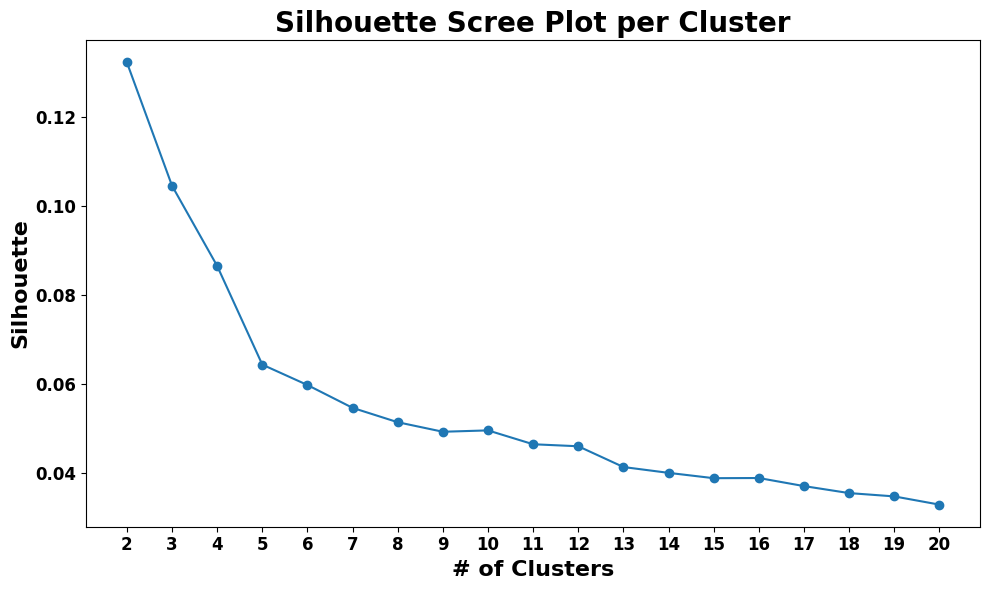

In [31]:
plot_score(no_of_clusters, silhouette_scores)

## Evaluate the Models

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

In [32]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

def plot_silhouette_analysis(models, silhouette_scores):
  for k in range(0, len(models)):
      clusterer = models[k]
      cluster_labels = clusterer.labels_
      n_clusters = len(np.unique(cluster_labels))

      # Create a subplot with 1 row and 2 columns
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_size_inches(18, 7)

      # The 1st subplot is the silhouette plot
      # The silhouette coefficient can range from -1, 1 but in this example all
      # lie within [-0.1, 1]
      ax1.set_xlim([-0.1, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
      ax1.set_ylim([0, len(_X) + (n_clusters + 1) * 10])


      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed
      # clusters
      silhouette_avg = silhouette_scores[k]
      print(
          "For n_clusters =",
          n_clusters,
          "The average silhouette_score is :",
          silhouette_avg,
      )

      # Compute the silhouette scores for each sample
      sample_silhouette_values = silhouette_samples(X, cluster_labels)

      y_lower = 10
      for i in range(n_clusters):
          # Aggregate the silhouette scores for samples belonging to
          # cluster i, and sort them
          ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

          ith_cluster_silhouette_values.sort()

          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          color = cm.nipy_spectral(float(i) / n_clusters)
          ax1.fill_betweenx(
              np.arange(y_lower, y_upper),
              0,
              ith_cluster_silhouette_values,
              facecolor=color,
              edgecolor=color,
              alpha=0.7,
          )

          # Label the silhouette plots with their cluster numbers at the middle
          ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

          # Compute the new y_lower for next plot
          y_lower = y_upper + 10  # 10 for the 0 samples

      ax1.set_title("The silhouette plot for the various clusters.")
      ax1.set_xlabel("The silhouette coefficient values")
      ax1.set_ylabel("Cluster label")

      # The vertical line for average silhouette score of all the values
      ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

      ax1.set_yticks([])  # Clear the yaxis labels / ticks
      ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      # 2nd Plot showing the actual clusters formed
      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
      ax2.scatter(
          _X[:, 0], _X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
      )

      # Labeling the clusters
      centers = clusterer.cluster_centers_
      # Draw white circles at cluster centers
      ax2.scatter(
          centers[:, 0],
          centers[:, 1],
          marker="o",
          c="white",
          alpha=1,
          s=200,
          edgecolor="k",
      )

      for i, c in enumerate(centers):
          ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

      ax2.set_title("The visualization of the clustered data.")
      ax2.set_xlabel("Feature space for the 1st feature")
      ax2.set_ylabel("Feature space for the 2nd feature")

      plt.suptitle(
          "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
          % n_clusters,
          fontsize=14,
          fontweight="bold",
      )

  plt.show()

For n_clusters = 2 The average silhouette_score is : 0.13217460191507044
For n_clusters = 3 The average silhouette_score is : 0.10451616170179363
For n_clusters = 4 The average silhouette_score is : 0.08652739215004002
For n_clusters = 5 The average silhouette_score is : 0.06439875957766233
For n_clusters = 6 The average silhouette_score is : 0.05982451494900226
For n_clusters = 7 The average silhouette_score is : 0.054704876343534735
For n_clusters = 8 The average silhouette_score is : 0.05148287187662381
For n_clusters = 9 The average silhouette_score is : 0.04934439862316491
For n_clusters = 10 The average silhouette_score is : 0.04965047814062885
For n_clusters = 11 The average silhouette_score is : 0.046542337913383657


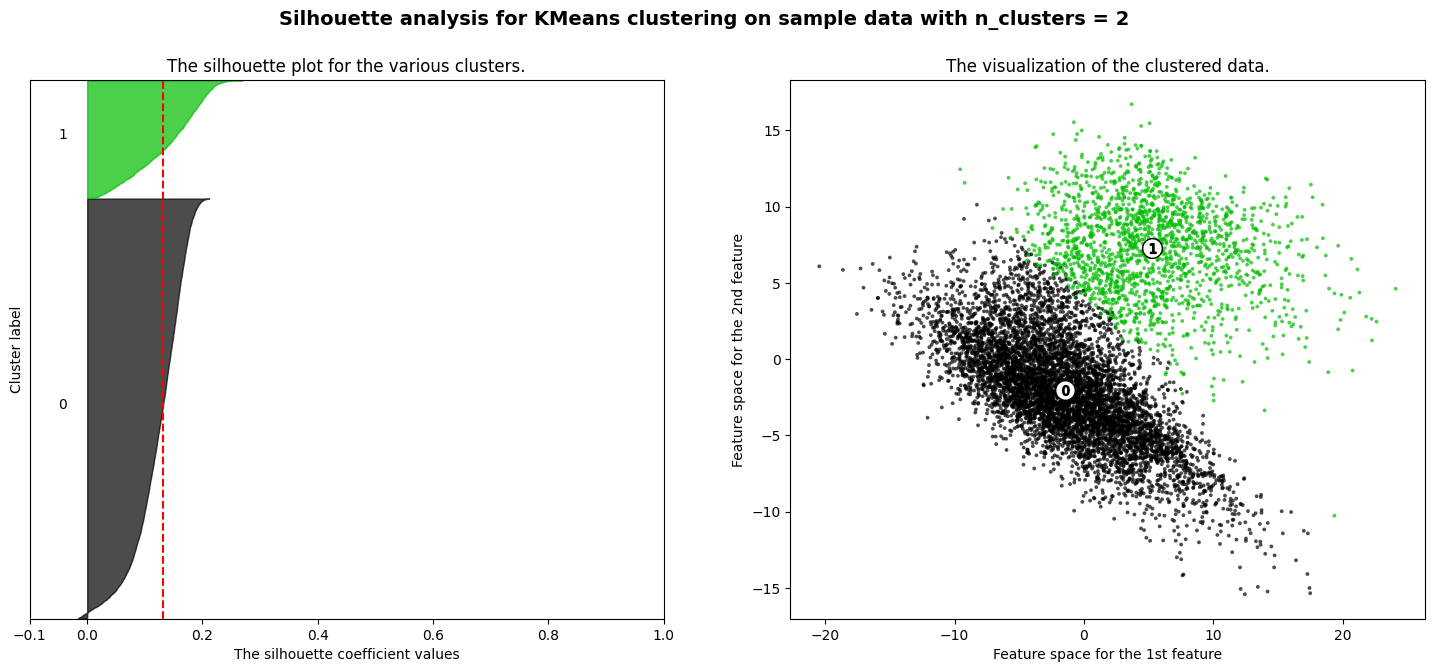

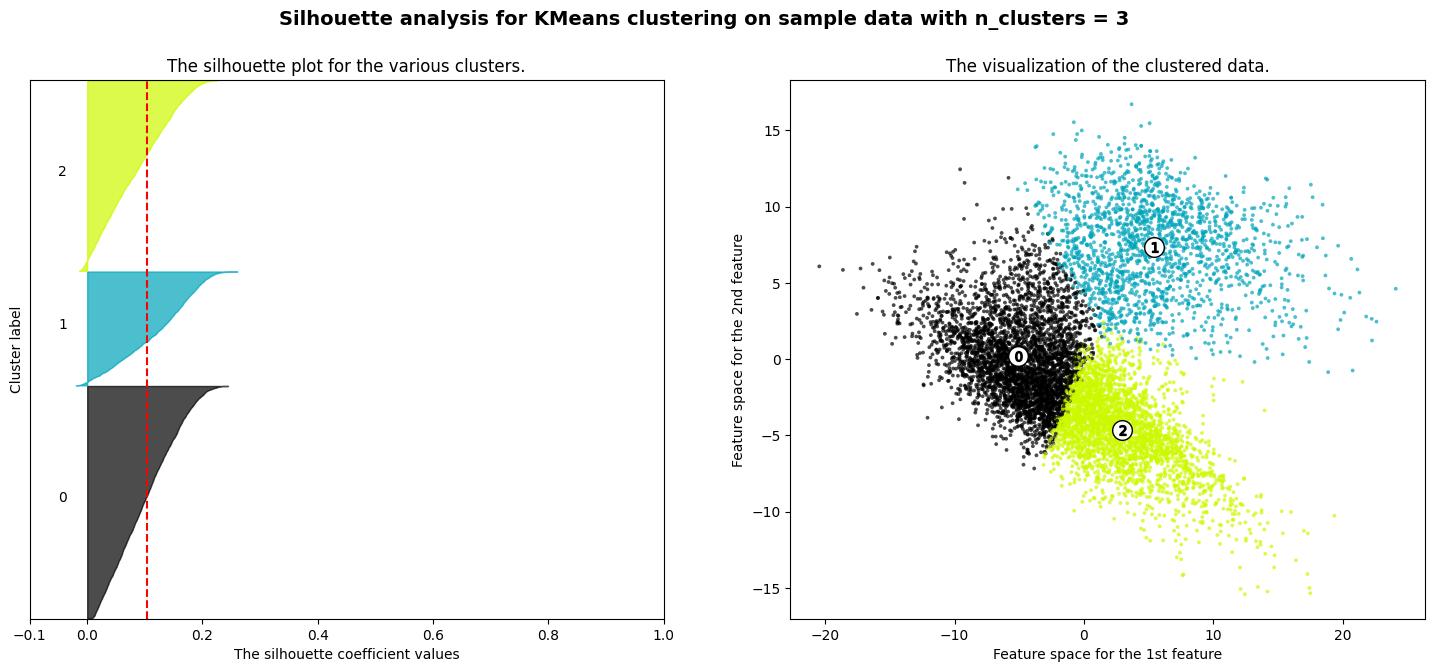

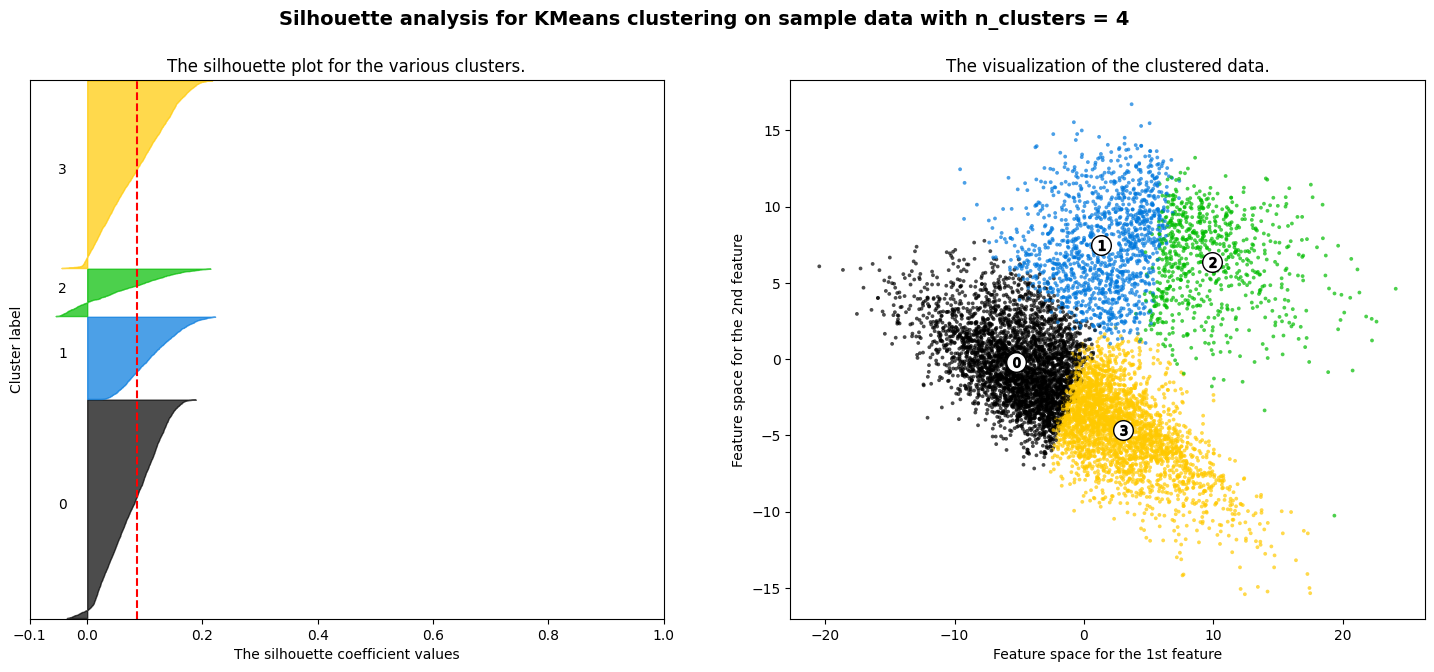

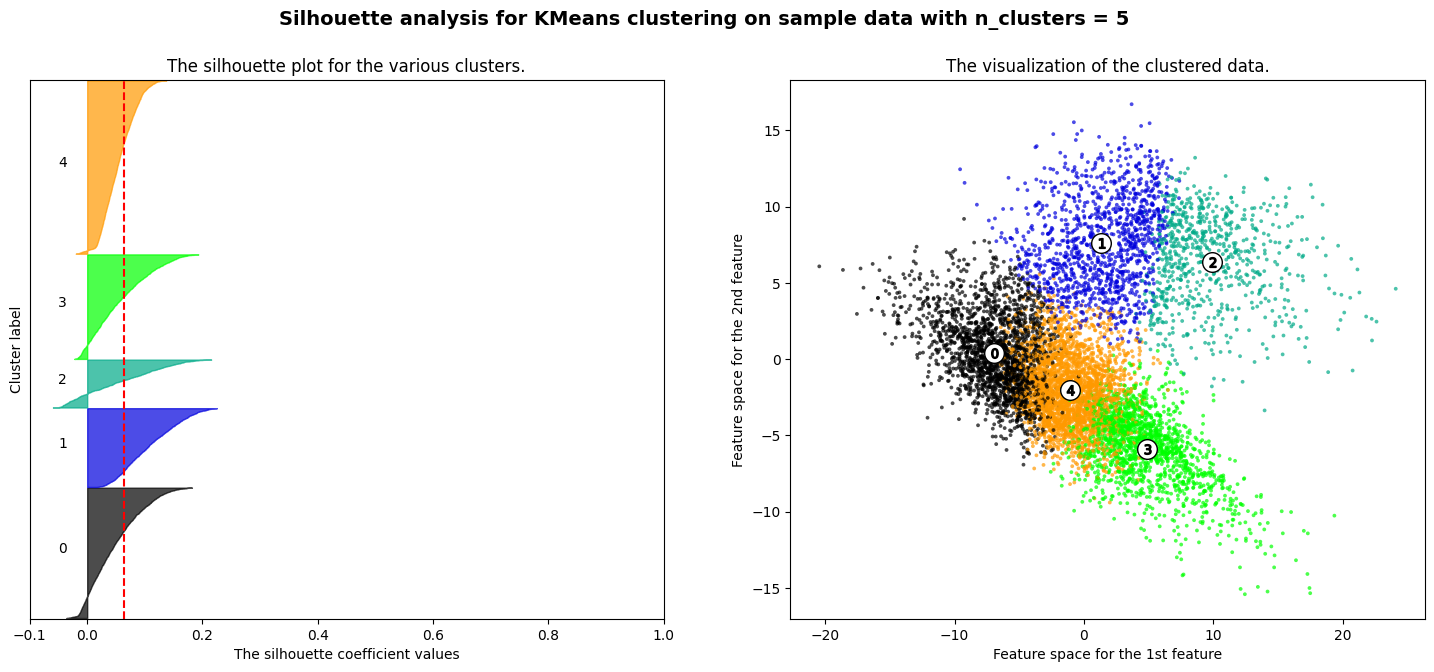

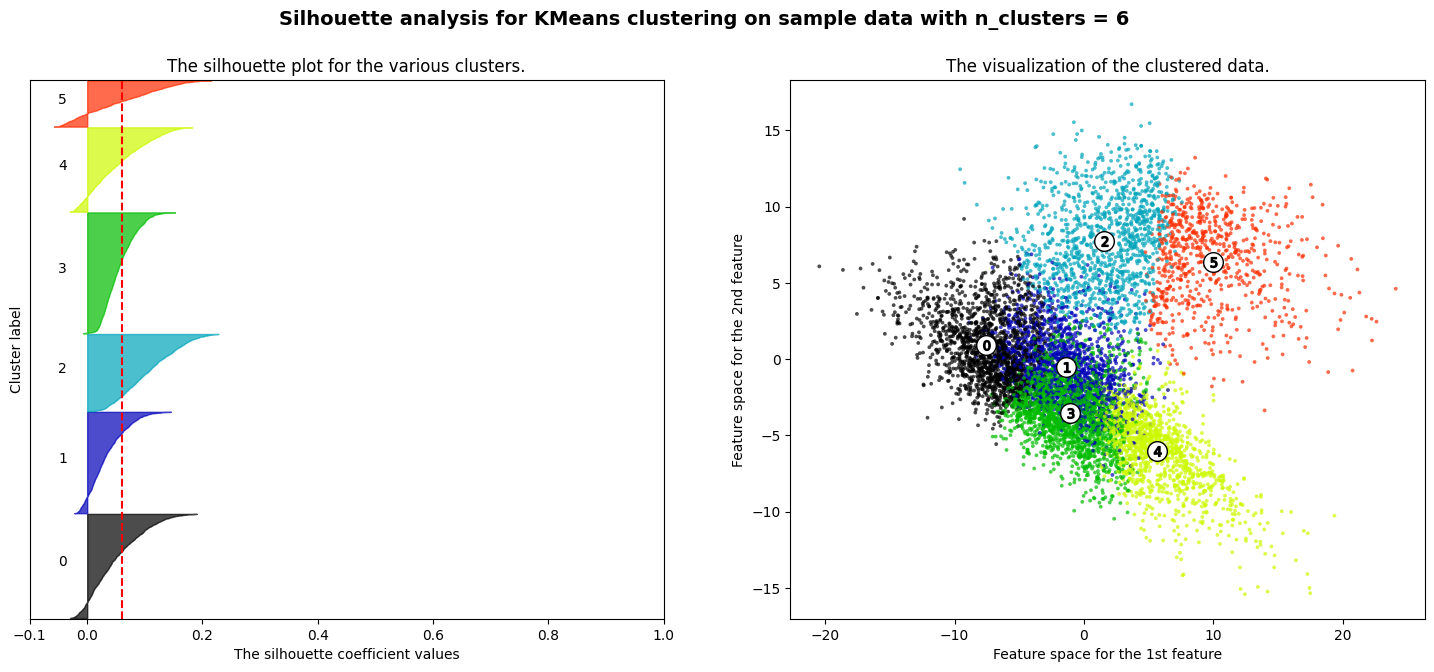

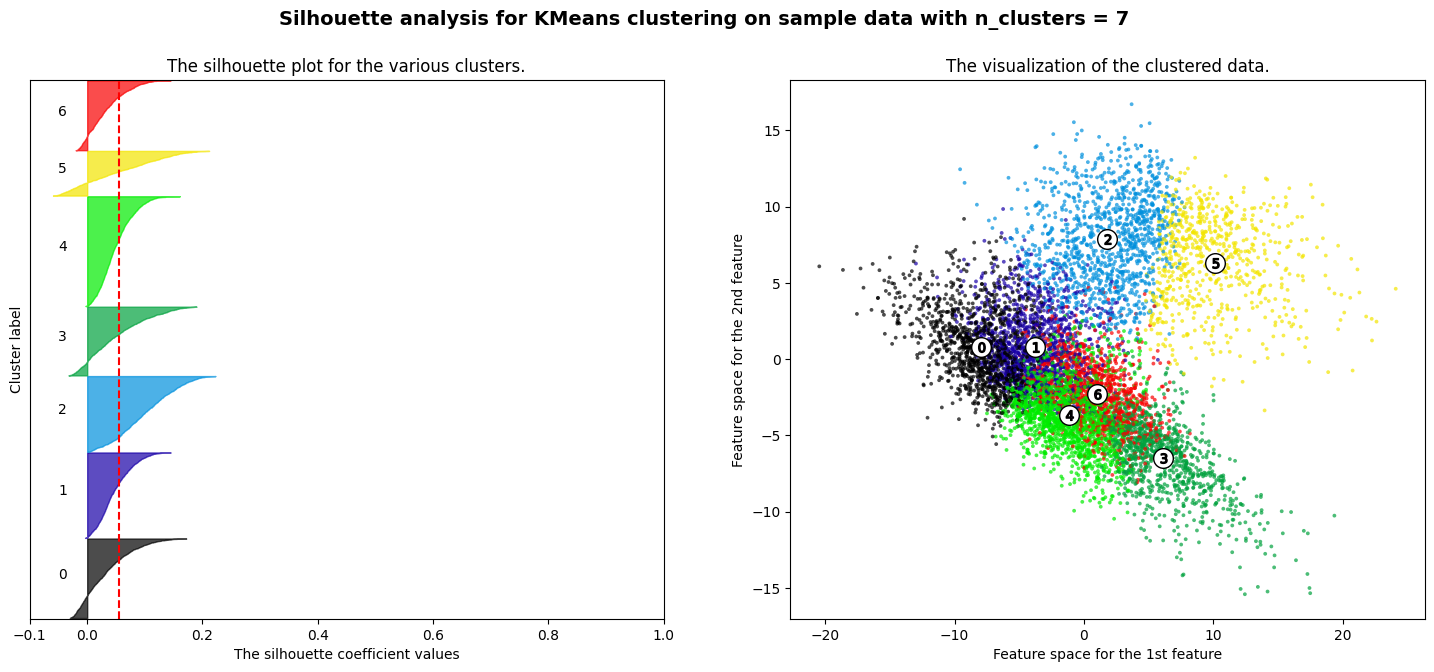

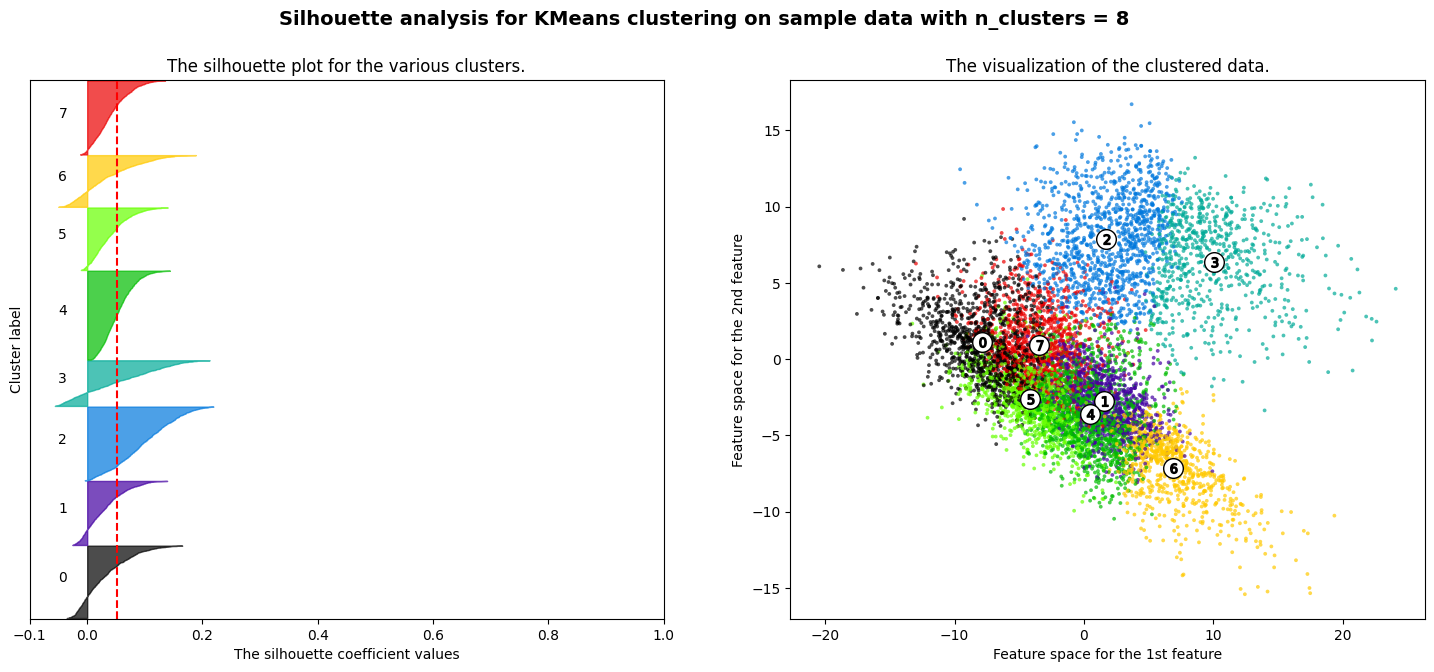

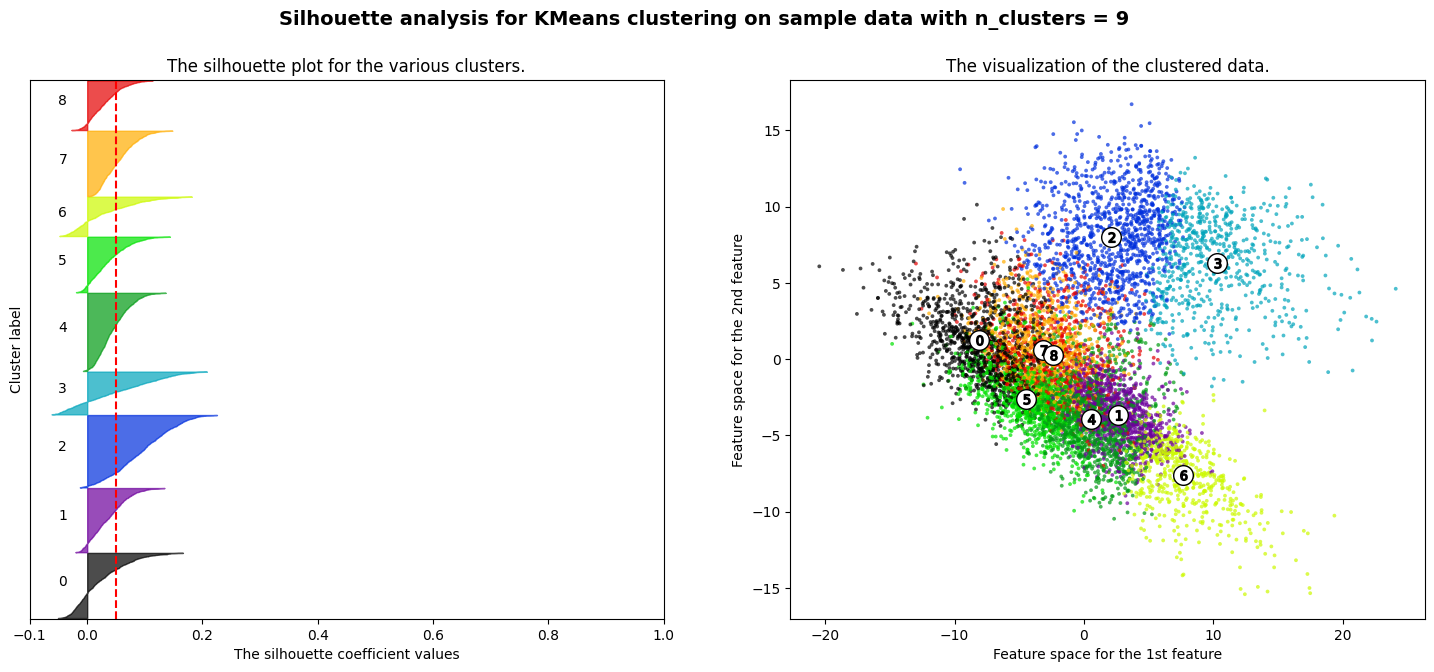

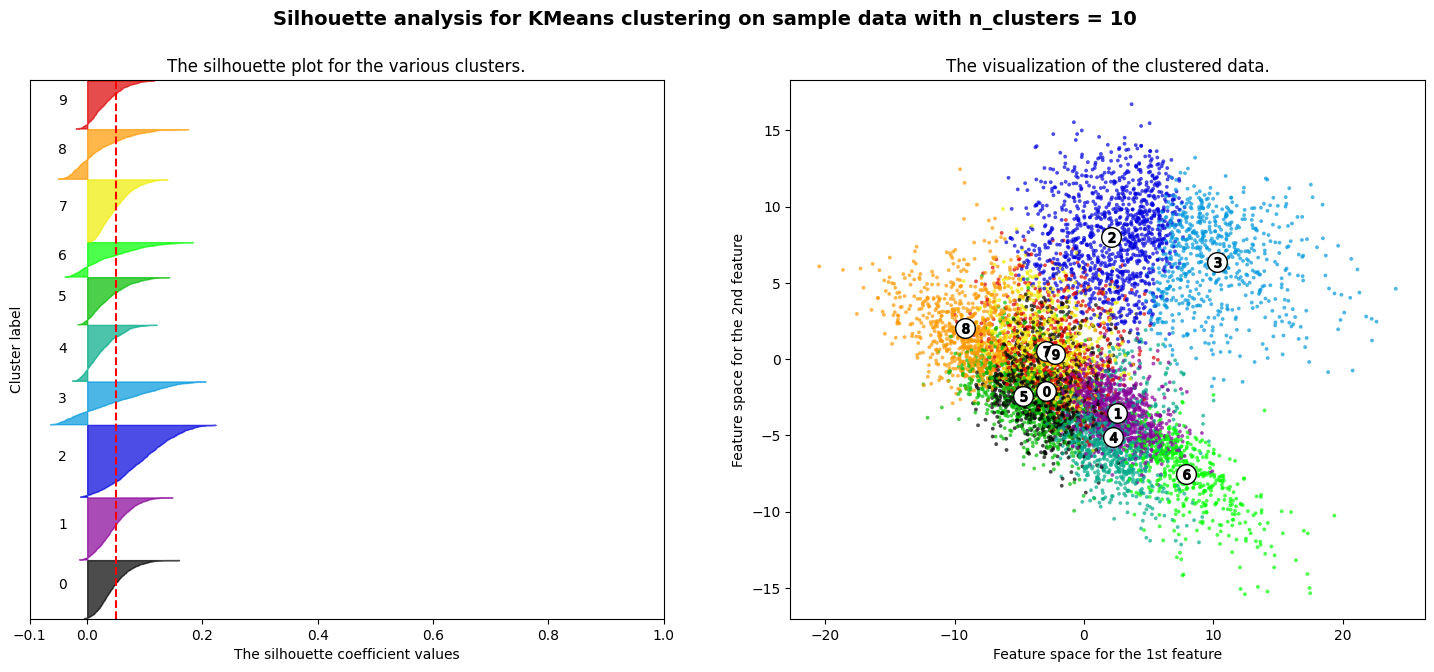

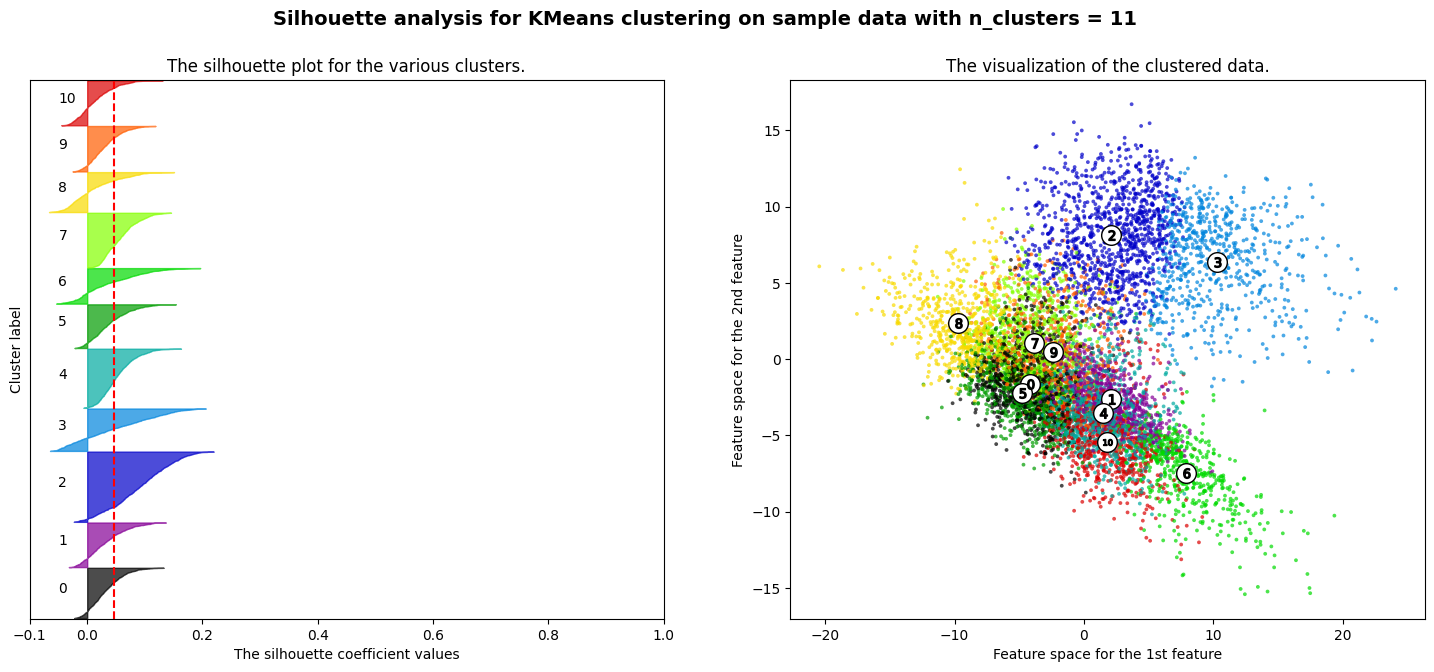

In [33]:
plot_silhouette_analysis(kmeans_models[:10], silhouette_scores)

## Try Other Algorithm - AgglomerativeClustering


In [34]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import cluster

for n in range(2, 10):
  agglo = cluster.FeatureAgglomeration(n_clusters=n)
  agglo.fit(_X)
  X_reduced = agglo.transform(_X)

  agg = AgglomerativeClustering(n_clusters=n)
  agg.fit(X_reduced)
  print("For n_clusters =",
          n,
          "The average silhouette_score is :",
          silhouette_score(_X, agg.labels_),
  )

For n_clusters = 2 The average silhouette_score is : 0.08922590487412195
For n_clusters = 3 The average silhouette_score is : 0.10635246528603062
For n_clusters = 4 The average silhouette_score is : 0.06914972053042326
For n_clusters = 5 The average silhouette_score is : 0.050223468371632225
For n_clusters = 6 The average silhouette_score is : 0.03684706755149441
For n_clusters = 7 The average silhouette_score is : 0.028028506065743246
For n_clusters = 8 The average silhouette_score is : 0.02498460433508026
For n_clusters = 9 The average silhouette_score is : 0.023571750527382848


# Summary and Discussion




*  Based on the **Kmeans** algorithm, we try to build the model with different n_cluster values, and use **Silhouette Coefficient** as the basis for evaluating the model.
*  For a dense dataset, dividing too many clusters will result in some clusters having only a few data points, which may not make any sense in the real world. Using our data as an example, *n_cluster=2* gets the highest score. And from the analysis plot, it is also more meaningful.
*  Different algorithms may has different results. For example, when we switch to **AgglomerativeClustering**, we get the highest score at *n_cluster=3*.

